# Pipeline for Simulating GRNS on Sergio & Packing into Anndata object

First, create the files 

Import the necessary modules

In [2]:
%load_ext autoreload
%autoreload 2

from matplotlib import pyplot as plt
from pyslingshot import Slingshot #for simulating pseudotimes
import numpy as np
import pandas as pd
import sys
import os
sys.path.append(os.path.abspath('../SERGIO'))
from SERGIO.sergio import sergio

/Users/JenChen/Desktop/otvelo/researchy/lib/python3.9/site-packages/pyslingshot/slingshot.py:11: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm


Simulate the GRN and save the splicing data to files

In [4]:
import os

def csv_to_txt(input_csv, output_folder="data_sets/De-noised_100G_4T_300cPerT_dynamics_10_DS5/txt_files"):
    os.makedirs(output_folder, exist_ok=True)
    output_txt = os.path.join(output_folder, os.path.basename(input_csv).replace(".csv", ".txt"))

    with open(input_csv, 'r') as csv_file, open(output_txt, 'w') as txt_file:
        for line in csv_file:
            txt_file.write(line.replace(',', ' '))

    print(f"Saved to {output_txt}")

# Example usage in Jupyter Notebook
input_csv = "data_sets/De-noised_100G_4T_300cPerT_dynamics_10_DS5/simulated_noNoise_U_1.csv"  # Change this as needed
csv_to_txt(input_csv)




Saved to data_sets/De-noised_100G_4T_300cPerT_dynamics_10_DS5/txt_files/simulated_noNoise_U_1.txt


# Compute pseudotimes

First create the txt file from csv to find the pseudotimes

In [5]:
import numpy as np
import pandas as pd
from anndata import AnnData

# Load the entire CSV (no header)
df = pd.read_csv("data_sets/De-noised_100G_4T_300cPerT_dynamics_10_DS5/simulated_noNoise_T_1.csv", header=None)

# First row is cluster labels (ignore first column)
cluster_labels = df.iloc[0, 1:].astype(int).values

# Remaining rows are gene expression data
data = df.iloc[1:, 1:].astype(float).values  # shape: (num_genes, num_cells)

# Transpose to shape (num_cells, num_genes)
data_T = data.T

# Create AnnData object
ad = AnnData(data_T)

# Set gene names
ad.var_names = [f"gene_{i}" for i in range(data.shape[0])]

# Set celltype labels
ad.obs["celltype"] = cluster_labels

# If you have UMAP or other dimensional reduction
# ad.obsm["X_umap"] = Xt_all[:, 0:2]

print(ad)


AnnData object with n_obs × n_vars = 1200 × 100
    obs: 'celltype'


In [6]:
data.shape

(100, 1200)

/var/folders/6s/mn0cx1qn7b901qdgrbh6z_hm0000gp/T/ipykernel_51816/369344071.py:15: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))


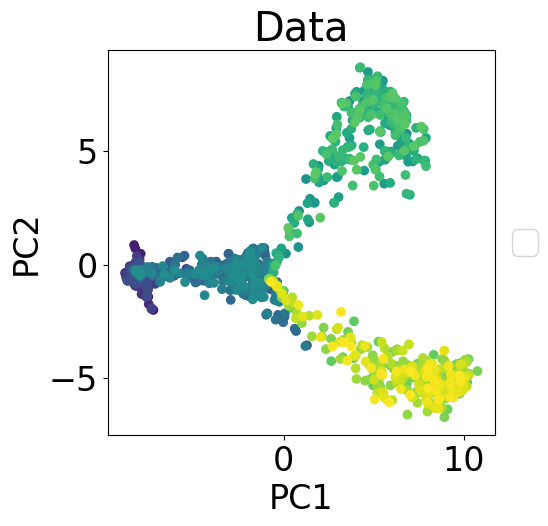

In [7]:
plt.rcParams["figure.figsize"] = (5,5)
        # PCAs:
from sklearn.decomposition import PCA
plt.rcParams["font.size"] = 24
pca = PCA()
Xt_all = pca.fit_transform(np.log2(data.T+1) ) 
plt.scatter(Xt_all[:,0],Xt_all[:,1], c=range(Xt_all.shape[0]) )
#         for j in range(Nt):
#             idx = range(num_cells_per_time*j, num_cells_per_time*(j+1))
#             plt.plot(Xt_all[idx,0],Xt_all[idx,1],'o-')
       
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('Data')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
        
plt.show()

In [8]:
Xt_all.shape

(1200, 100)

In [25]:
# # from sklearn.cluster import KMeans
# from anndata import AnnData
# # num_clusters = 9  # Set the number of clusters you want for KMeans

# # # Apply KMeans clustering
# # kmeans = KMeans(n_clusters=num_clusters, random_state=42)
# # cluster_labels = kmeans.fit_predict(Xt_all)  # Using PCA components for clustering
# cluster_labels = np.zeros( (300) )
# cluster_labels[0:100] = 0
# cluster_labels[100:200] = 1
# cluster_labels[200:300] = 2
# cluster_labels=np.int8(cluster_labels)

In [9]:
cluster_labels[0]

0

Create anndata obj

In [29]:
num_cells = data.shape[1]
num_genes = data.shape[0]
ad = AnnData(data.T)
ad.obsm["X_umap"] = Xt_all[:,0:2]
ad.obsm["X_umap"] /= 10.0
ad.obs["celltype"] = cluster_labels

In [30]:
cluster_labels

array([0, 0, 0, ..., 3, 3, 3])

/Users/JenChen/Desktop/otvelo/researchy/lib/python3.9/site-packages/pyslingshot/util.py:37: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if isint(cluster_labels[0]):


Lineages: [Lineage[0, 1, 2], Lineage[0, 1, 3]]


  0%|          | 0/1 [00:00<?, ?it/s]

Reversing from leaf to root
Averaging branch @1 with lineages: [0, 1] [<pcurvepy2.pcurve.PrincipalCurve object at 0x7fd499a4f9a0>, <pcurvepy2.pcurve.PrincipalCurve object at 0x7fd4ab8ea670>]
Shrinking branch @1 with curves: [<pcurvepy2.pcurve.PrincipalCurve object at 0x7fd499a4f9a0>, <pcurvepy2.pcurve.PrincipalCurve object at 0x7fd4ab8ea670>]


100%|██████████| 1/1 [00:02<00:00,  2.45s/it]


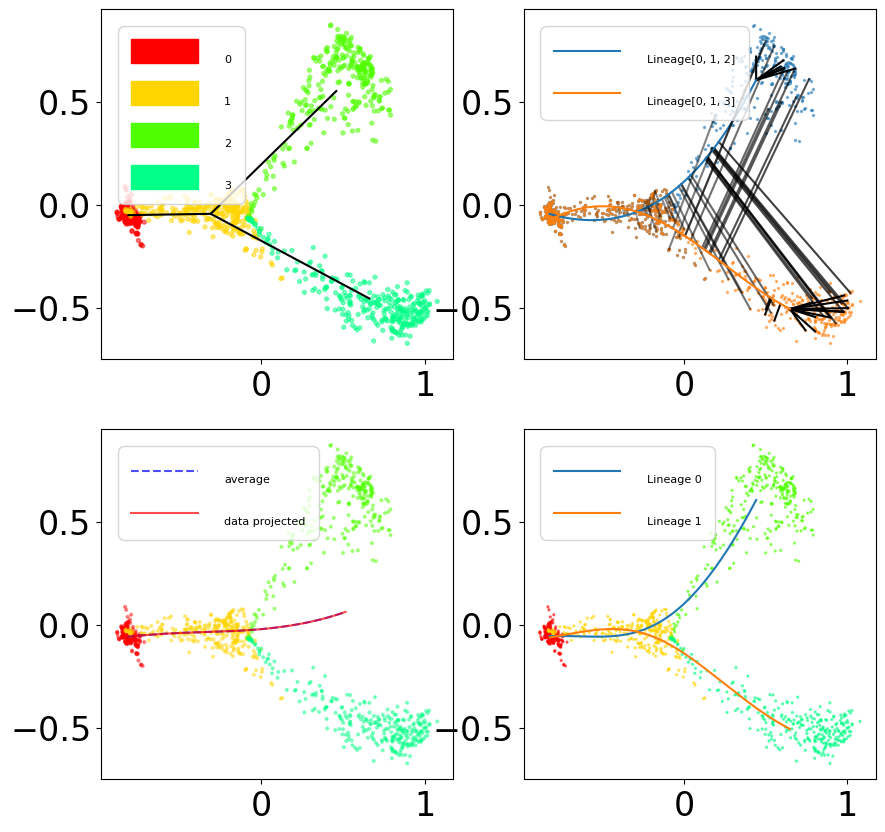

In [35]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10, 10))
custom_xlim = (-12, 12)
custom_ylim = (-12, 12)

slingshot = Slingshot(ad, celltype_key="celltype", obsm_key="X_umap", start_node=0, debug_level='verbose')


slingshot.fit(num_epochs=1, debug_axes=axes)

# Adjust legend size
for ax in axes.flatten():
    legend = ax.get_legend()
    if legend:
        legend.set_title(legend.get_title().get_text(), prop={'size': 10})  # Reduce legend title size
        for text in legend.get_texts():
            text.set_fontsize(8)  # Reduce legend item text size


In [23]:
pseudotime = slingshot.unified_pseudotime
ad.obs["pseudotime"] = slingshot.unified_pseudotime

print(type(slingshot.unified_pseudotime))  # Check the object type
print(slingshot.unified_pseudotime.shape)  # Check its dimensions
print(slingshot.unified_pseudotime[:5])    # Print first few values


<class 'numpy.ndarray'>
(1200,)
[0.         0.42300631 0.         0.         0.        ]


In [25]:
# data = np.loadtxt( "data_linear.txt" )

#data = np.load("data_bifurcate.npy")
def analyze_txt(input_txt):
    with open(input_txt, 'r') as txt_file:
        expected_columns = None
        for i, line in enumerate(txt_file):
            columns = line.strip().split()  # Split line into columns based on spaces
            num_columns = len(columns)
            
            if expected_columns is None:
                expected_columns = num_columns  # Set initial expected columns
            
            if num_columns != expected_columns:
                print(f"Column mismatch at row {i}: expected {expected_columns}, found {num_columns}")
            
            print(f"Row {i}: {num_columns} columns")  # Print column count for each row

# Need to get rid of the first col as it only represents the number of each row/gene for some reason
input_txt = 'data_sets/De-noised_100G_4T_300cPerT_dynamics_10_DS5/txt_files/simulated_noNoise_U_1.txt'  # Replace with your actual TXT file path
analyze_txt(input_txt)

input_path = "data_sets/De-noised_100G_4T_300cPerT_dynamics_10_DS5/txt_files/simulated_noNoise_U_1.txt"

with open(input_path, "r") as f:
    lines = f.readlines()

with open(input_path, "w") as f:
    for i, line in enumerate(lines):
        parts = line.strip().split()
        if i == 0:
            cleaned = parts
        else:
            cleaned = parts[1:]
        f.write(" ".join(cleaned) + "\n")



Row 0: 1200 columns
Column mismatch at row 1: expected 1200, found 1201
Row 1: 1201 columns
Column mismatch at row 2: expected 1200, found 1201
Row 2: 1201 columns
Column mismatch at row 3: expected 1200, found 1201
Row 3: 1201 columns
Column mismatch at row 4: expected 1200, found 1201
Row 4: 1201 columns
Column mismatch at row 5: expected 1200, found 1201
Row 5: 1201 columns
Column mismatch at row 6: expected 1200, found 1201
Row 6: 1201 columns
Column mismatch at row 7: expected 1200, found 1201
Row 7: 1201 columns
Column mismatch at row 8: expected 1200, found 1201
Row 8: 1201 columns
Column mismatch at row 9: expected 1200, found 1201
Row 9: 1201 columns
Column mismatch at row 10: expected 1200, found 1201
Row 10: 1201 columns
Column mismatch at row 11: expected 1200, found 1201
Row 11: 1201 columns
Column mismatch at row 12: expected 1200, found 1201
Row 12: 1201 columns
Column mismatch at row 13: expected 1200, found 1201
Row 13: 1201 columns
Column mismatch at row 14: expected 

Add splicing data to anndata object also

In [26]:
#skip the header row
spliced_data = np.loadtxt("data_sets/De-noised_100G_4T_300cPerT_dynamics_10_DS5/txt_files/simulated_noNoise_S_1.txt", skiprows=1) #spliced RNA
unspliced_data = np.loadtxt("data_sets/De-noised_100G_4T_300cPerT_dynamics_10_DS5/txt_files/simulated_noNoise_U_1.txt",skiprows=1) #unspliced RNA

# Ensure the shape matches adata.X (genes x cells)
print(spliced_data.shape)  # Should be (num_genes, num_cells)
print(unspliced_data.shape)  # Should be (num_genes, num_cells)
print(ad.layers.keys())
# Transpose if necessary (AnnData assumes cells x genes)
if spliced_data.shape[1] == ad.n_obs and spliced_data.shape[0] == ad.n_vars:
    ad.layers["spliced"] = spliced_data.T  # Ensure it aligns with AnnData structure
    print('done w spliced')
else:
    raise ValueError("Shape mismatch! Check if genes and cells are correctly aligned.")

if unspliced_data.shape[1] == ad.n_obs and unspliced_data.shape[0] == ad.n_vars:
    ad.layers["unspliced"] = unspliced_data.T  # Ensure it aligns with AnnData structure
    print('done w unspliced')
else:
    raise ValueError("Shape mismatch! Check if genes and cells are correctly aligned.")

# Print splicing data info
print("spliced data shape:", ad.layers["spliced"].shape)
print("spliced data (first 5 genes, first 5 cells):\n", ad.layers["spliced"][:5, :5])
print("unspliced data shape:", ad.layers["unspliced"].shape)
print("unspliced data (first 5 genes, first 5 cells):\n", ad.layers["unspliced"][:5, :5])

# Print pseudotime data info
print("Pseudotime data shape:", ad.obs["pseudotime"].shape)
print("Pseudotime values (first 10 cells):\n", ad.obs["pseudotime"].head(10))
print(ad.layers.keys())



(100, 1200)
(100, 1200)
KeysView(Layers with keys: )
done w spliced
done w unspliced
spliced data shape: (1200, 100)
spliced data (first 5 genes, first 5 cells):
 [[ 7.04806479  1.51845843 14.61753239 10.33030143 18.55660956]
 [ 7.15199754  1.51843695 15.45866321 10.20927392 17.29597667]
 [ 7.02046875  1.6143022  16.04807961 10.07294449 17.52833977]
 [ 6.87084604  1.5344394  14.97489    10.08217067 17.90439768]
 [ 6.37211093  1.53716561 14.58555766 10.2109258  17.66535866]]
unspliced data shape: (1200, 100)
unspliced data (first 5 genes, first 5 cells):
 [[2.03756456 0.39070415 2.83665967 3.11127894 4.35767273]
 [1.76819579 0.20095473 3.16484057 2.65517163 4.34037765]
 [1.13588794 0.4738448  3.54098675 2.56041587 4.85695977]
 [1.81077123 0.39104709 4.15392818 2.30427348 4.39084633]
 [2.14096991 0.20171702 3.25396908 2.35205407 5.14686069]]
Pseudotime data shape: (1200,)
Pseudotime values (first 10 cells):
 0    0.000000
1    0.423006
2    0.000000
3    0.000000
4    0.000000
5    0.000

/var/folders/6s/mn0cx1qn7b901qdgrbh6z_hm0000gp/T/ipykernel_51816/332775482.py:15: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))


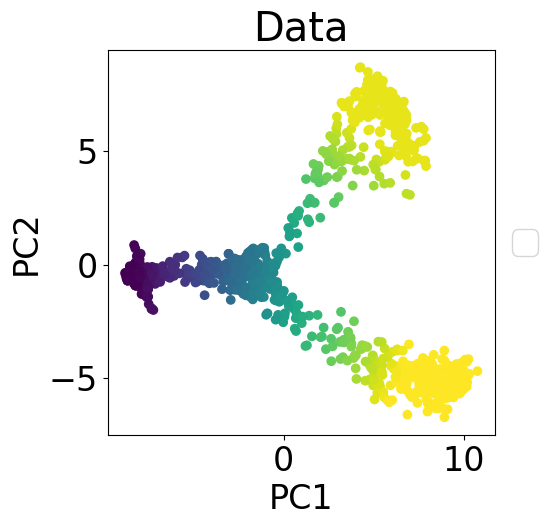

In [27]:
plt.rcParams["figure.figsize"] = (5,5)
        # PCAs:
from sklearn.decomposition import PCA
plt.rcParams["font.size"] = 24
pca = PCA()
Xt_all = pca.fit_transform(np.log2(data.T+1) ) 
plt.scatter(Xt_all[:,0],Xt_all[:,1], c=pseudotime )
#         for j in range(Nt):
#             idx = range(num_cells_per_time*j, num_cells_per_time*(j+1))
#             plt.plot(Xt_all[idx,0],Xt_all[idx,1],'o-')
#how to keep track of which cell is corr to which branch
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('Data')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
        
plt.show()

In [28]:
ad.write("100g4t300cds5.h5ad")
ad

AnnData object with n_obs × n_vars = 1200 × 100
    obs: 'celltype', 'pseudotime'
    obsm: 'X_umap'
    layers: 'spliced', 'unspliced'